In [1]:
from datetime import datetime
from datetime import timedelta
import os
import math
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
import tensorflow_addons as tfa

# tf.test.is_gpu_available()
# tf.config.list_physical_devices('GPU')

## Def functions: One-Hot Encoding and Split Data (Dataframe)

In [2]:
def Get_ListOfLabels(df_InputLabels):
    df_Tags = df_InputLabels.str.split(expand=True)
    columns = len(df_Tags.columns)

    for i in range(columns):
        if i == 0:
            df_aux = pd.DataFrame(df_Tags[0])
        else:
            df_aux = df_aux.append(pd.DataFrame(df_Tags[i].rename(index=0)))

    LabelList = (df_aux.drop_duplicates().sort_values([0], ascending=[True]))[0].tolist()
    LabelList = list(filter(None, LabelList))
    return LabelList


def Get_LabelEncodedArray(df_InputLabels, LabelList):
    LabelArray = np.zeros((df_InputLabels.count(), len(LabelList)))
    TagsArray = df_InputLabels.str.split(expand=True).to_numpy()

    for i in range(TagsArray.shape[0]):
        for j in range(TagsArray.shape[1]):
            for k in range(len(LabelList)):
                if(TagsArray[i][j]== LabelList[k]):
                    LabelArray[i][k] = 1

    return LabelArray

def OneHotToStringLabels(OneHotArray, LabelList, delimiter):
    string_labels = ""
    if(len(OneHotArray)!=len(LabelList)):
        raise Exception("OneHotArray does not match LabelList len/size")

    for i in range(len(OneHotArray)):
        if(OneHotArray[i] == 1.0):
            if(string_labels == ""):
                string_labels = LabelList[i]
            else:
                string_labels = string_labels+delimiter+LabelList[i]
    return string_labels

def SplitData(df_Dataset, Ratio):

    df_TrainData = pd.DataFrame(df_Dataset).sample(round(Ratio * df_Dataset['filename'].count()))

    df_ValData = pd.DataFrame(df_Dataset)
    condition = df_ValData['filename'].isin(df_TrainData['filename'])
    df_ValData = df_ValData.drop(df_ValData[condition].index)

    return df_TrainData, df_ValData

### **Encoding labels:** One-Hot

In [3]:
source_path = "../input/amazon-satellite/raw-data"
source_path_Labels = os.path.join(source_path, 'train_v2.csv')
source_path_Images = os.path.join(source_path, 'train-jpg')

df_Raw = pd.read_csv(source_path_Labels)
LabelList = Get_ListOfLabels(df_Raw.tags)

Get_LabelEncodedArray(df_Raw.tags, LabelList)
df_Dataset = pd.DataFrame(Get_LabelEncodedArray(df_Raw.tags, LabelList), columns=LabelList)
df_Dataset['filename'] = df_Raw.image_name.to_list()
df_Dataset['filename'] = df_Dataset['filename']+'.jpg'
df_Dataset = df_Dataset.loc[: , ['filename']+LabelList]

## Data Exploration
- Finding correlation between classes/labels and mutual exclusivity

In [4]:
# Find labels with high correlation
df_corr = df_Dataset.corr()
print(df_corr[df_corr>0.3])

                   agriculture  artisinal_mine  bare_ground  blooming  \
agriculture           1.000000             NaN          NaN       NaN   
artisinal_mine             NaN             1.0          NaN       NaN   
bare_ground                NaN             NaN          1.0       NaN   
blooming                   NaN             NaN          NaN       1.0   
blow_down                  NaN             NaN          NaN       NaN   
clear                      NaN             NaN          NaN       NaN   
cloudy                     NaN             NaN          NaN       NaN   
conventional_mine          NaN             NaN          NaN       NaN   
cultivation           0.344964             NaN          NaN       NaN   
habitation            0.303979             NaN          NaN       NaN   
haze                       NaN             NaN          NaN       NaN   
partly_cloudy              NaN             NaN          NaN       NaN   
primary                    NaN             NaN     

In [5]:
# Find labels with low correlation
df_corr = df_Dataset.corr()
print(df_corr[df_corr<-0.2])

                   agriculture  artisinal_mine  bare_ground  blooming  \
agriculture                NaN             NaN          NaN       NaN   
artisinal_mine             NaN             NaN          NaN       NaN   
bare_ground                NaN             NaN          NaN       NaN   
blooming                   NaN             NaN          NaN       NaN   
blow_down                  NaN             NaN          NaN       NaN   
clear                      NaN             NaN          NaN       NaN   
cloudy                     NaN             NaN          NaN       NaN   
conventional_mine          NaN             NaN          NaN       NaN   
cultivation                NaN             NaN          NaN       NaN   
habitation                 NaN             NaN          NaN       NaN   
haze                       NaN             NaN          NaN       NaN   
partly_cloudy              NaN             NaN          NaN       NaN   
primary                    NaN             NaN     

In [6]:
# Verify mutual exclusivity of 4 labels: clear, haze, partly_cloudy, cloudy

print('Images labelled as clear AND haze:\t\t\t'+str(df_Dataset.loc[(df_Dataset['clear']==1.0) & (df_Dataset['haze']==1.0)]['filename'].count()))
print('Images labelled as clear AND partly_cloudy:\t\t'+str(df_Dataset.loc[(df_Dataset['clear']==1.0) & (df_Dataset['partly_cloudy']==1.0)]['filename'].count()))
print('Images labelled as clear AND cloudy:\t\t\t'+str(df_Dataset.loc[(df_Dataset['clear']==1.0) & (df_Dataset['cloudy']==1.0)]['filename'].count()))
print('Images labelled as haze AND partly_cloudy:\t\t'+str(df_Dataset.loc[(df_Dataset['haze']==1.0) & (df_Dataset['partly_cloudy']==1.0)]['filename'].count()))
print('Images labelled as haze AND cloudy:\t\t\t'+str(df_Dataset.loc[(df_Dataset['haze']==1.0) & (df_Dataset['cloudy']==1.0)]['filename'].count()))
print('Images labelled as partly_cloudy AND cloudy:\t\t'+str(df_Dataset.loc[(df_Dataset['partly_cloudy']==1.0) & (df_Dataset['cloudy']==1.0)]['filename'].count()))

print('\nImages with any of these 4 labels:\t'+str(df_Dataset.loc[(df_Dataset['clear']==1.0) | (df_Dataset['haze']==1.0) | (df_Dataset['partly_cloudy']==1.0) | (df_Dataset['cloudy']==1.0)]['filename'].count()))
print('Images without any of these 4 labels:\t'+str(df_Dataset.loc[~((df_Dataset['clear']==1.0) | (df_Dataset['haze']==1.0) | (df_Dataset['partly_cloudy']==1.0) | (df_Dataset['cloudy']==1.0))]['filename'].count()))
print('total number of images:\t\t\t'+str(df_Raw.tags.count()))

Images labelled as clear AND haze:			0
Images labelled as clear AND partly_cloudy:		0
Images labelled as clear AND cloudy:			0
Images labelled as haze AND partly_cloudy:		0
Images labelled as haze AND cloudy:			0
Images labelled as partly_cloudy AND cloudy:		0

Images with any of these 4 labels:	40478
Images without any of these 4 labels:	1
total number of images:			40479


In [7]:
# Verify mutual exclusivity of 4 labels: artisinal_mine and conventional_mine

print('Images labelled as artisinal_mine AND conventional_mine: '+str(df_Dataset.loc[(df_Dataset['artisinal_mine']==1.0) & (df_Dataset['conventional_mine']==1.0)]['filename'].count()))
print('Images labelled as artisinal_mine OR conventional_mine: '+str(df_Dataset.loc[(df_Dataset['artisinal_mine']==1.0) | (df_Dataset['conventional_mine']==1.0)]['filename'].count()))

Images labelled as artisinal_mine AND conventional_mine: 4
Images labelled as artisinal_mine OR conventional_mine: 435


## Training and Validation Generators

Now that you know the images you are dealing with, it is time for you to code the generators that will fed these images to your Network. For this, complete the `train_val_generators` function below:

**Important Note:** The images have a resolution of 256x256 but the `flow_from_dataframe` method you will use allows you to set a target resolution. Lower resolution may yield much quicker training times without compromising the accuracy!

In [8]:
def generate_generator_multiple(generator, directory, df1, df2, df3, df4, df5, batch_size, target_size):
    genX1 = generator.flow_from_dataframe(dataframe = df1,
                                          directory=directory,
                                          x_col=df1.columns[0],
                                          y_col=df1.columns[1:len(df1.columns)],
                                          target_size = target_size,
                                          class_mode = 'raw',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    
    genX2 = generator.flow_from_dataframe(dataframe = df2,
                                          directory=directory,
                                          x_col=df2.columns[0],
                                          y_col=df2.columns[1:len(df2.columns)],
                                          target_size = target_size,
                                          class_mode = 'raw',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    
    genX3 = generator.flow_from_dataframe(dataframe = df3,
                                          directory=directory,
                                          x_col=df3.columns[0],
                                          y_col=df3.columns[1:len(df3.columns)],
                                          target_size = target_size,
                                          class_mode = 'raw',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    
    genX4 = generator.flow_from_dataframe(dataframe = df4,
                                          directory=directory,
                                          x_col=df4.columns[0],
                                          y_col=df4.columns[1:len(df4.columns)],
                                          target_size = target_size,
                                          class_mode = 'raw',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    
    genX5 = generator.flow_from_dataframe(dataframe = df5,
                                          directory=directory,
                                          x_col=df5.columns[0],
                                          y_col=df5.columns[1:len(df5.columns)],
                                          target_size = target_size,
                                          class_mode = 'raw',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    
    for i in range(df1['filename'].count()):
            X1i = genX1.next()
            X2i = genX2.next()
            X3i = genX3.next()
            X4i = genX4.next()
            X5i = genX5.next()
            yield X1i[0],[X1i[1], X2i[1], X3i[1], X4i[1], X5i[1]]


            
            
            
# Get Data Generators
def train_val_generators(DIRECTORY, df_Train, df_Validation):
    
  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values and set arguments to augment the images 
  train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                     rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.1,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

# create generator
  df_vis = df_Train.loc[:, ['filename', 'clear', 'haze', 'partly_cloudy', 'cloudy']]
  df_hum = df_Train.loc[:, ['filename', 'agriculture', 'cultivation', 'habitation']]
  df_rw  = df_Train.loc[:, ['filename', 'road', 'water']]
  df_prim = df_Train.loc[:, ['filename', 'primary']]
  df_rem = df_Train.loc[:, ['filename', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'conventional_mine', 'selective_logging', 'slash_burn']]

  train_generator = generate_generator_multiple(train_datagen, DIRECTORY, df_vis, df_hum, df_rw, df_prim, df_rem, 32, (256, 256))
    
#   train_generator = train_datagen.flow_from_dataframe(dataframe=df_Train,
#                                                       directory=DIRECTORY,
#                                                       x_col=df_Train.columns[0],
#                                                       y_col=df_Train.columns[1:len(df_Train.columns)],
#                                                       batch_size=32, 
#                                                       class_mode='raw',
#                                                       target_size=(256, 256))

  # Instantiate the ImageDataGenerator class (set the rescale argument)
  # Validation data not augmented
  validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
    
  df_vis = df_ValData.loc[:, ['filename', 'clear', 'haze', 'partly_cloudy', 'cloudy']]
  df_hum = df_ValData.loc[:, ['filename', 'agriculture', 'cultivation', 'habitation']]
  df_rw  = df_ValData.loc[:, ['filename', 'road', 'water']]
  df_prim = df_ValData.loc[:, ['filename', 'primary']]
  df_rem = df_ValData.loc[:, ['filename', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'conventional_mine', 'selective_logging', 'slash_burn']]

  validation_generator = generate_generator_multiple(validation_datagen, DIRECTORY, df_vis, df_hum, df_rw, df_prim, df_rem, 32, (256, 256))
  
#   flow_from_dataframe method
#   validation_generator = validation_datagen.flow_from_dataframe(dataframe=df_Validation,
#                                                                 directory=DIRECTORY,
#                                                                 x_col=df_ValData.columns[0],
#                                                                 y_col=df_ValData.columns[1:len(df_ValData.columns)],
#                                                                 batch_size=32,
#                                                                 class_mode='raw',
#                                                                 target_size=(256, 256))
  return train_generator, validation_generator

In [9]:
# Split Data
TrainToValidation_DataSize_Ratio = 0.6
df_TrainData, df_ValData = SplitData(df_Dataset, TrainToValidation_DataSize_Ratio)

# Test Generators
train_generator, validation_generator = train_val_generators(source_path_Images, df_TrainData, df_ValData)

## Test Image Data Generator and Label Encoding
- Verify if functions are working and visualize data

In [10]:
# data_index = 0

# print(pd.DataFrame(np.array([LabelList, validation_generator.labels[data_index]]).transpose()).to_string(index=False))
# print("\nFile name:\t"+validation_generator.filenames[data_index])
# print("Labels:\t\t"+OneHotToStringLabels(validation_generator.labels[data_index], LabelList, ' ')+'\n')

# img = mpimg.imread(os.path.join(source_path_Images, validation_generator.filenames[data_index]))
# img = img[:,:,:3]
# plt.imshow(img)

## Model Definition
- Import InceptionV3 weights and define layers connected
- Import VGG19 weights and define layers connected

In [11]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

def create_model():
    
    Input = tf.keras.Input(shape=(256, 256, 3))
    
#     #Load InceptionResNetV2 Model
    Model_1 = tf.keras.applications.InceptionResNetV2(input_tensor = Input, include_top = False, weights="imagenet")
    #Make all layers on InceptionResNetV2 trainable
    for layer in Model_1.layers:
        layer.trainable = True
    x_Model_1 = Model_1(Input)
    x_Model_1_Flat = tf.keras.layers.Flatten(name='Flatten_Model_1')(x_Model_1)
    
    
#     #Load VGG19 Model
    Model_2 = tf.keras.applications.VGG19(input_tensor = Input, include_top=False, weights="imagenet")
    #Make all layers on VGG19 trainable
    for layer in Model_2.layers:
            layer.trainable = True
    x_Model_2 = Model_2(Input)
    x_Model_2_Flat = tf.keras.layers.Flatten(name='Flatten_Model_2')(x_Model_2)
    
    
    x_Top = tf.keras.layers.Concatenate(name='ConcatenateFlatten_Layer')([x_Model_1_Flat, x_Model_2_Flat])
    x_Top = tf.keras.layers.Dense(1024)(x_Top)
    
    #Define Visibility Branch
    # x_vis[0] -> clear
    # x_vis[1] -> haze
    # x_vis[2] -> partly_cloudy
    # x_vis[3] -> cloudy
    x_vis = tf.keras.layers.Dense(512, activation='relu')(x_Top)
    x_vis = tf.keras.layers.BatchNormalization()(x_vis)
    x_vis = tf.keras.layers.Dropout(0.2)(x_vis)
    x_vis = tf.keras.layers.Dense(512, activation='relu')(x_vis)
    x_vis = tf.keras.layers.BatchNormalization()(x_vis)
    x_vis = tf.keras.layers.Dropout(0.4)(x_vis)
    x_vis = tf.keras.layers.Dense(256, activation='relu')(x_vis)
    x_vis = tf.keras.layers.BatchNormalization()(x_vis)
    x_vis = tf.keras.layers.Dropout(0.4)(x_vis)
    x_vis = tf.keras.layers.Dense(4, activation='softmax', name = 'visibility')(x_vis)
    
    #Define Human Activity Branch
    # x_hum[0] -> agriculture
    # x_hum[1] -> cultivation
    # x_hum[2] -> habitation
    x_hum = tf.keras.layers.Dense(512, activation='relu')(x_Top)
    x_hum = tf.keras.layers.BatchNormalization()(x_hum)
    x_hum = tf.keras.layers.Dropout(0.2)(x_hum)
    x_hum = tf.keras.layers.Dense(512, activation='relu')(x_hum)
    x_hum = tf.keras.layers.BatchNormalization()(x_hum)
    x_hum = tf.keras.layers.Dropout(0.4)(x_hum)
    x_hum = tf.keras.layers.Dense(256, activation='relu')(x_hum)
    x_hum = tf.keras.layers.BatchNormalization()(x_hum)
    x_hum = tf.keras.layers.Dropout(0.4)(x_hum)
    x_hum = tf.keras.layers.Dense(3, activation='sigmoid', name='human_activity')(x_hum)
    
    #Define Track Branch (Road or Water)
    # x_rw[0] -> road
    # x_rw[1] -> water
    x_rw = tf.keras.layers.Dense(512, activation='relu')(x_Top)
    x_rw = tf.keras.layers.BatchNormalization()(x_rw)
    x_rw = tf.keras.layers.Dropout(0.2)(x_rw)
    x_rw = tf.keras.layers.Dense(512, activation='relu')(x_rw)
    x_rw = tf.keras.layers.BatchNormalization()(x_rw)
    x_rw = tf.keras.layers.Dropout(0.4)(x_rw)
    x_rw = tf.keras.layers.Dense(256, activation='relu')(x_rw)
    x_rw = tf.keras.layers.BatchNormalization()(x_rw)
    x_rw = tf.keras.layers.Dropout(0.4)(x_rw)
    x_rw = tf.keras.layers.Dense(2, activation='sigmoid', name='road_water')(x_rw)
    
    #Define Primary Branch
    #x_primary[0] -> primary
    x_prim = tf.keras.layers.Dense(512, activation='relu')(x_Top)
    x_prim = tf.keras.layers.BatchNormalization()(x_prim)
    x_prim = tf.keras.layers.Dropout(0.2)(x_prim)
    x_prim = tf.keras.layers.Dense(512, activation='relu')(x_prim)
    x_prim = tf.keras.layers.BatchNormalization()(x_prim)
    x_prim = tf.keras.layers.Dropout(0.4)(x_prim)
    x_prim = tf.keras.layers.Dense(256, activation='relu')(x_prim)
    x_prim = tf.keras.layers.BatchNormalization()(x_prim)
    x_prim = tf.keras.layers.Dropout(0.4)(x_prim)
    x_prim = tf.keras.layers.Dense(1, activation='sigmoid', name='primary')(x_prim)
    
    
    #Define Remaining Branch
    #x_mine[0] -> artisinal_mine
    # x_rem[1] -> bare_ground
    # x_rem[2] -> blooming
    # x_rem[3] -> blow_down
    #x_mine[4] -> conventional_mine
    # x_rem[5] -> selective_logging
    # x_rem[6] -> slash_burn
    x_rem = tf.keras.layers.Dense(512, activation='relu')(x_Top)
    x_rem = tf.keras.layers.BatchNormalization()(x_rem)
    x_rem = tf.keras.layers.Dropout(0.2)(x_rem)
    x_rem = tf.keras.layers.Dense(512, activation='relu')(x_rem)
    x_rem = tf.keras.layers.BatchNormalization()(x_rem)
    x_rem = tf.keras.layers.Dropout(0.4)(x_rem)
    x_rem = tf.keras.layers.Dense(256, activation='relu')(x_rem)
    x_rem = tf.keras.layers.BatchNormalization()(x_rem)
    x_rem = tf.keras.layers.Dropout(0.4)(x_rem)
    x_rem = tf.keras.layers.Dense(7, activation='sigmoid', name='remaining')(x_rem)
    
    model = tf.keras.Model(inputs=Input, outputs=[x_vis, x_hum, x_rw, x_prim, x_rem])

    model.compile(optimizer=Adam(lr=1e-4),
                loss='binary_crossentropy',
                metrics={
                         'visibility': [tfa.metrics.FBetaScore(beta=2.0, num_classes=4 , average='micro', threshold=0.5)],
                         'human_activity': [tfa.metrics.FBetaScore(beta=2.0, num_classes=3 , average='micro', threshold=0.5)],
                         'road_water': [tfa.metrics.FBetaScore(beta=2.0, num_classes=2 , average='micro', threshold=0.5)],
                         'primary': [tfa.metrics.FBetaScore(beta=2.0, num_classes=1 , average='micro', threshold=0.5)],
                         'remaining': [tfa.metrics.FBetaScore(beta=2.0, num_classes=7 , average='micro', threshold=0.5)]
                        }
               ) 
    return model

## Callback to stop training

In [12]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        print("\nReached FBeta Score = "+str(statistics.harmonic_mean([logs.get('val_visibility_fbeta_score'), logs.get('val_human_activity_fbeta_score'), logs.get('val_road_water_fbeta_score'), logs.get('val_primary_fbeta_score')])))

## Model Training

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History

model = create_model()
BATCH_SIZE = 32

callbacks = [History(),
            myCallback(),
            EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
            ModelCheckpoint(filepath='/kaggle/working/InceptionResNetVGG19.h5', monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True, mode='auto')]

model_history = model.fit_generator(train_generator,
                    steps_per_epoch = math.ceil(df_TrainData['filename'].count()/BATCH_SIZE),
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator,
                    validation_steps = math.ceil(df_ValData['filename'].count()/BATCH_SIZE),
                    callbacks=callbacks
                   )

history = model_history.history

2022-05-29 16:01:35.354076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 16:01:35.472498: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 16:01:35.473368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 16:01:35.474482: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 24287 validated image filenames.
Found 24287 validated image filenames.
Found 24287 validated image filenames.
Found 24287 validated image filenames.
Found 24287 validated image filenames.


2022-05-29 16:03:14.906373: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-05-29 16:03:38.834480: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


759/759 [==============================] - ETA: 0s - loss: 3.1717 - visibility_loss: 0.6007 - human_activity_loss: 0.6604 - road_water_loss: 0.5761 - primary_loss: 0.5765 - remaining_loss: 0.7579 - visibility_fbeta_score: 0.6315 - human_activity_fbeta_score: 0.5390 - road_water_fbeta_score: 0.6031 - primary_fbeta_score: 0.7870 - remaining_fbeta_score: 0.0416Found 16192 validated image filenames.
Found 16192 validated image filenames.
Found 16192 validated image filenames.
Found 16192 validated image filenames.
Found 16192 validated image filenames.
759/759 [==============================] - 2513s 3s/step - loss: 3.1717 - visibility_loss: 0.6007 - human_activity_loss: 0.6604 - road_water_loss: 0.5761 - primary_loss: 0.5765 - remaining_loss: 0.7579 - visibility_fbeta_score: 0.6315 - human_activity_fbeta_score: 0.5390 - road_water_fbeta_score: 0.6031 - primary_fbeta_score: 0.7870 - remaining_fbeta_score: 0.0416 - val_loss: 18.6043 - val_visibility_loss: 12.6979 - val_human_activity_loss: 

## Save/Load Keras Model and History

In [14]:
# Save
import pickle
from keras.models import load_model
with open("/kaggle/working/InceptionResNetVGG19.pkl", 'wb') as f:
    pickle.dump(history, f)
model.save("/kaggle/working/InceptionResNetVGG19_EndTrain.h5")

In [15]:
# # Load
# from tensorflow import keras
# import pickle
# model = keras.models.load_model("/kaggle/working/InceptionV3_Untrainable_V2.h5")
# with open("/kaggle/working/InceptionV3_Untrainable_V2.pkl", 'rb') as f:
#     history = pickle.load(f)

## Plot History

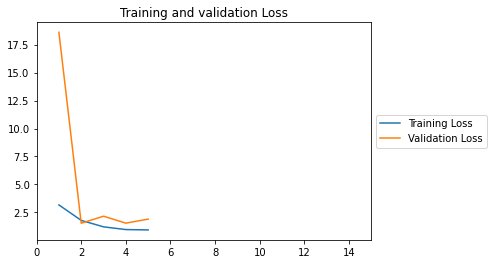

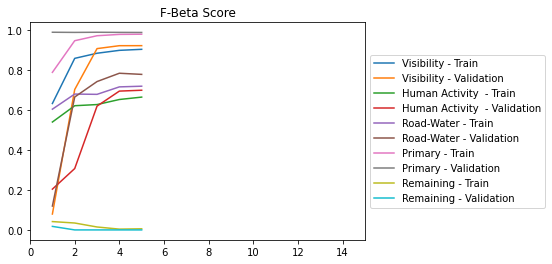

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history['loss']
val_loss=history['val_loss']

epochs=np.array(range(len(loss)))+1 # Get number of epochs

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title('Training and validation Loss')
plt.xlim([0, 15])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#------------------------------------------------
# Plot training and validation F Scores per epoch
#------------------------------------------------
plt.plot(epochs, history['visibility_fbeta_score'], label="Visibility - Train")
plt.plot(epochs, history['val_visibility_fbeta_score'], label="Visibility - Validation")
plt.plot(epochs, history['human_activity_fbeta_score'], label="Human Activity  - Train")
plt.plot(epochs, history['val_human_activity_fbeta_score'], label="Human Activity  - Validation")
plt.plot(epochs, history['road_water_fbeta_score'], label="Road-Water - Train")
plt.plot(epochs, history['val_road_water_fbeta_score'], label="Road-Water - Validation")
plt.plot(epochs, history['primary_fbeta_score'], label="Primary - Train")
plt.plot(epochs, history['val_primary_fbeta_score'], label="Primary - Validation")
plt.plot(epochs, history['remaining_fbeta_score'], label="Remaining - Train")
plt.plot(epochs, history['val_remaining_fbeta_score'], label="Remaining - Validation")
plt.title('F-Beta Score')
plt.xlim([0, 15])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Submission

In [17]:
import matplotlib.image as mpimg
from IPython.display import clear_output

def GetPredictions(df_Submission, ImageFolderPath):

    start_time = datetime.now()
    iteration_time = start_time
    df_Submission.image_name = df_Submission.image_name+'.jpg'

    predicted = np.array([np.zeros(4), np.zeros(3), np.zeros(2), np.zeros(2), np.zeros(6)], dtype=object)
    predicted = [predicted]*df_Submission.image_name.count()

    for i, row in enumerate(df_Submission.to_numpy()):
        img = mpimg.imread(os.path.join(ImageFolderPath, row[0]))
        img = img[:,:,:3]
        img = np.array([img])
        predicted[i] = model.predict(img)
        iteration_elapsed = datetime.now()-iteration_time
        if(iteration_elapsed.total_seconds()>5.00):
            iteration_time = datetime.now()
            elapsed_time = (datetime.now()-start_time)
            estimate_to_completion = (elapsed_time/i)*(df_Submission.count()[0]-i)
            clear_output(wait=True)
            print('Completed\t\t\t', "{:.2f}".format(100*i/df_Submission.image_name.count()),'%')
            print('Elapsed time:\t\t', elapsed_time)
            print('Estimate to completion:\t', estimate_to_completion)

    clear_output(wait=True)
    print('completed 100 %')
    elapsed_time = (datetime.now()-start_time)
    print('Elapsed time: ', elapsed_time)
    return predicted

def GetPedictGeneratorOutput(prediction, index):
    return [predictions[0][index], predictions[1][index], predictions[2][index], predictions[3][index], predictions[4][index]]

def GetLabelsFromPrediction(ModelOutput, threshold):
    label = ""
    if(ModelOutput[1][0] > threshold):
        label = label + " agriculture"
    if(ModelOutput[4][0] > threshold):
        label = label + " artisinal_mine"
    if(ModelOutput[4][1] > threshold):
        label = label + " bare_ground"
    if(ModelOutput[4][2] > threshold):
        label = label + " blooming"
    if(ModelOutput[4][3] > threshold):
        label = label + " blow_down"
    if(ModelOutput[0][0] > threshold):
        label = label + " clear"
    if(ModelOutput[0][3] > threshold):
        label = label + " cloudy"
    if(ModelOutput[4][4] > threshold):
        label = label + " conventional_mine"
    if(ModelOutput[1][1] > threshold):
        label = label + " cultivation"
    if(ModelOutput[1][2] > threshold):
        label = label + " habitation"
    if(ModelOutput[0][1] > threshold):
        label = label + " haze"
    if(ModelOutput[0][2] > threshold):
        label = label + " partly_cloudy"
    if(ModelOutput[3][0] > threshold):
        label = label + " primary"
    if(ModelOutput[2][0] > threshold):
        label = label + " road"
    if(ModelOutput[4][5] > threshold):
        label = label + " selective_logging"
    if(ModelOutput[4][6] > threshold):
        label = label + " slash_burn"
    if(ModelOutput[2][1] > threshold):
        label = label + " water"
    return label.lstrip()


def InsertLabels_Dataframe(df_Submission, predicted, threshold):
    pred = []
    for i in range(len(predicted[0])):
        pred.append([])
        pred[i] = [predicted[0][i], predicted[1][i], predicted[2][i], predicted[3][i], predicted[4][i]]
    for i, ModelOutput in enumerate(pred):
        df_Submission['tags'][i]=GetLabelsFromPrediction(ModelOutput, threshold)

In [18]:
df_Submission = pd.read_csv('../input/amazon-satellite/raw-data/sample_submission_v2/sample_submission_v2.csv')
Test_FolderPath = '../input/amazon-satellite/raw-data/test-jpg'

df_Submission['image_name'] = df_Submission['image_name'] + '.jpg'

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
validation_generator = validation_datagen.flow_from_dataframe(dataframe=df_Submission,
                                                                directory=Test_FolderPath,
                                                                x_col=df_Submission.columns[0],
                                                                y_col=df_Submission.columns[1:len(df_Submission.columns)],
                                                                batch_size=32,
                                                                class_mode='raw',
                                                                shuffle=False,
                                                                target_size=(256, 256))

predictions = model.predict(validation_generator, verbose=1)
InsertLabels_Dataframe(df_Submission, predictions, threshold=0.5)

df_Submission['image_name'] = df_Submission['image_name'].str.replace('.jpg', '')
df_Submission.to_csv('/kaggle/working/submission.csv', index=None)

Found 61191 validated image filenames.
1913/1913 [==============================] - 570s 296ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
